In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
# Setting the path for the dataset
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

# Loading the prepared data
to = load_pickle(path/'to.pkl')

In [3]:
# Splitting the data into training and validation x and y
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [4]:
# Replacing years <1900 with 1950
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [5]:
# Function to calculate the RMSE
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

# Tabular Modelling Deep Dive

## Random Forests
In 1994 Berkeley professor Leo Breiman, one year after his retirement, published a small technical report called ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), which turned out to be one of the most influential ideas in modern machine learning. The report began:

> : Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Here is the procedure that Breiman is proposing:

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
2. Train a model using this subset.
3. Save that model, and then return to step 1 a few times.
4. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

In 2001 Leo Breiman went on to demonstrate that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the *random forest*. Today it is, perhaps, the most widely used and practically important machine learning method.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

### Creating a Random Forest
We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [6]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [7]:
model = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

In [8]:
m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0.171386, 0.232867)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.


To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

In [10]:
preds = np.stack([t.predict(valid_xs) for t in model.estimators_]);

/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286

As you can see, `preds.mean(0)` gives the same results as our random forest:

In [11]:
r_mse(preds.mean(0), valid_y)

0.232867

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

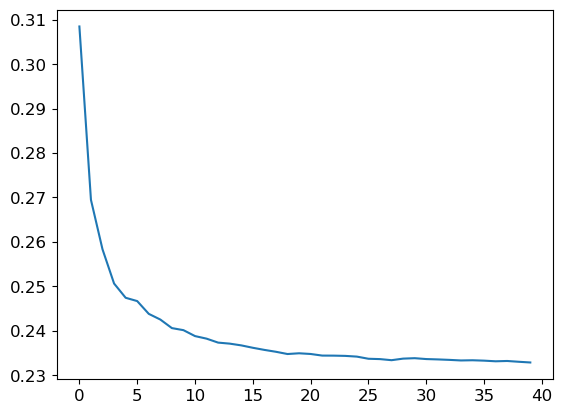

In [12]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called *out-of-bag* (OOB) error that can help us with this (and more!).

### Out-of-Bag Error
Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [13]:
r_mse(model.oob_prediction_, y)

0.211271

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.